Imports

In [10]:
import torch
import torchvision
import torchvision.datasets as datasets                                                     
import torchvision.transforms 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn as nn
import torch.nn.functional

import numpy as np

import os.path 
import sys

Load data

In [11]:
params = {"padding" : (300,300)}

In [12]:
##### Defining transforms #####
pad = torchvision.transforms.Pad(padding = params["padding"], fill = 0) # pad smaller images to desired size
centercrop = torchvision.transforms.CenterCrop(300) # Crop images to be of same 300x300
greyscale = orchvision.transforms.Grayscale(num_output_channels=1) # Images are B/W but in 3 channels, we only need one

#Compose transforms
composed_transforms = torchvision.transforms.Compose([centercrop, greyscale,
                torchvision.transforms.ToTensor()])

#Create transformer class
class DatasetTransformer(torch.utils.data.Dataset):
    
    def __init__(self, base_dataset, transforms):
        self.base_dataset = base_dataset
        self.transform = transforms

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)

In [13]:
##### Loading Data #####
print(os.path.exists("/mounts/Datasets1/ChallengeDeep/train/"))
train_path = "/mounts/Datasets1/ChallengeDeep/train/"
valid_ratio = 0.2

# Load learning data
print('ok')
train_path = "/mounts/Datasets1/ChallengeDeep/train/"
dataset = datasets.ImageFolder(train_path,composed_transforms)
print('ok')

True
ok
ok


In [14]:
# Train test split 
nb_train = int((1.0 - valid_ratio) * len(dataset))
nb_valid =  len(dataset)-nb_train
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(dataset, [nb_train, nb_valid])

In [15]:
##### Generating Loaders #####
num_workers = 4
batch_size = 64

# training loader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = batch_size,
                                            num_workers = num_workers,
                                            shuffle = True)

# validation loader
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset,
                                            batch_size = batch_size,
                                            num_workers= num_workers,
                                            shuffle = True)

# Data Inspect
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))

The train set contains 684315 images, in 10693 batches
The validation set contains 171079 images, in 2674 batches


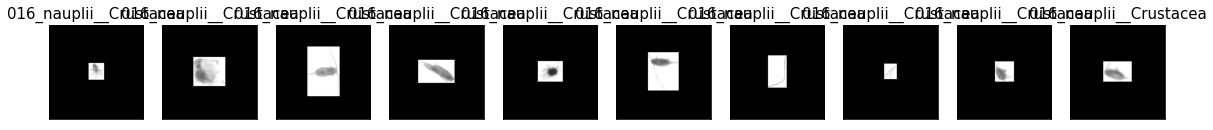

In [19]:
##### Display Some data #####
n_samples = 10

class_names = dataset.classes
imgs, labels = next(iter(train_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(n_samples) : 
    ax = plt.subplot(1,n_samples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(class_names[labels[0]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('plancton.png', bbox_inches='tight')
plt.show()

In [ ]:
##### Model construction items #####

# A convolutional base block
def conv_relu_maxpool(cin, cout, csize, cstride, cpad, msize, mstride, mpad):
    return [nn.Conv2d(cin, cout, csize, cstride, cpad),
        nn.ReLu(inplace=True),
        nn.MaxPool2d(msize, mstride, mpad)]

# A linear base block
def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in,dim_out),
                nn.Relu(inplace=True)]

# Compute convolution output
def out_size(conv_model):
    dummy_output = conv_model(torch.zeros((1, 1, 300, 300)))
    return np.prod(dummy_output.shape[1:] )

# Loss function 
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2  
        assert y_true.ndim == 1
        y_true = nn.functional.one_hot(y_true, -1).to(torch.float32) # qui va à la place du -1
        y_pred = nn.functional.softmax(y_pred, dim=1)
        
        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)  # clamp ?
        return 1 - f1.mean()
    
f_loss = F1_loss

dummy_loss = f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))) # f1 test
print("on calcule une loss f1 de : {}".format(dummy_loss))

# Optimizer 
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
##### Building a Model #####

class convClassifier(nn.Module):
    
    def __init__(self, num_classes):
        super(convClassifier, self).__init__()
        self.conv_model = nn.sequential(*conv_relu_maxpool(cin=1, cout=32,
                       csize=3, cstride=1, cpad=1,
                       msize=2, mstride=2, mpad=0),
                    *conv_relu_maxpool(cin=1, cout=64,
                       csize=3, cstride=1, cpad=1,
                       msize=2, mstride=2, mpad=0))
                       
        output_size = out_size(self.conv_model)
        self.fc_model = nn.sequential(*linear_relu(output_size,256),
                                        nn.Linear(256, num_classes))
    
    def forward(self, x):
        x = x.view(x.size[0], -1)
        x = self.conv_model(x)
        y = self.fc_model(x)
        return y

model = convClassifier(num_classes=len(dataset.classes))

use_gpu = torch.cuda.is_available()
if use_gpu :
    device = torch.device('cuda')
else : 
    device = torch.device('cpu')

model.to(device)

In [ ]:
##### training and testing #####

# One train step
def train(model, loader, f_loss, optimizer, device):

    # enter train mode
    model.train()
    
    N = 0
    tot_loss, correct = 0.0, 0.0

    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the forward pass through the network up to the loss
        outputs = model(inputs)
        loss = f_loss(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the exact number of processed samples
        N += inputs.shape[0]

        # Accumulate the loss considering
        tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

        # For the accuracy, we compute the labels for each input image
        predicted_targets = outputs.argmax(dim=1)
        correct += (predicted_targets == targets).sum().item()
        
        print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(tot_loss/N, correct/N))

# Test
def test(model, loader, f_loss, device):
    
    # We disable gradient computation 
    with torch.no_grad():
        
        # We enter evaluation mode
        model.eval()
        
        N = 0
        tot_loss, correct = 0.0, 0.0
        
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Compute the forward pass, i.e. the scores for each input image
            outputs = model(inputs)

            # Accumulate the exact number of processed samples
            N += inputs.shape[0]

            # Accumulate the loss considering
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()

            # For the accuracy, we compute the labels for each input image
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
            
        return tot_loss/N, correct/N

In [ ]:
##### Save the best model #####

def generate_unique_logpath(logdir, raw_run_name):
    i = 0
    while(True):
        run_name = raw_run_name + "_" + str(i)
        log_path = os.path.join(logdir, run_name)
        if not os.path.isdir(log_path):
            return log_path
        i = i + 1

# 1- create the logs directory if it does not exist
top_logdir = "./logs"
if not os.path.exists(top_logdir):
    os.mkdir(top_logdir)
    
logdir = generate_unique_logpath(top_logdir, "run")
print("Logging to {}".format(logdir))

class ModelCheckpoint:

    def __init__(self, filepath, model):
        self.min_loss = None
        self.filepath = filepath
        self.model = model

    def update(self, loss):
        if (self.min_loss is None) or (loss < self.min_loss):
            print("Saving a better model")
            torch.save(self.model.state_dict(), self.filepath)
            self.min_loss = loss

# Define the callback object
model_checkpoint = ModelCheckpoint(logdir + "/best_model.pt", model)

In [ ]:
##### learning loop #####
epochs = 5

for t in range(epochs):
    print("Epoch {}".format(t))
    train(model, train_loader, f_loss, optimizer, device)

    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
    model_checkpoint.update(val_loss)

In [ ]:
##### Save a summary of the run #####

summary_file = open(logdir + "/summary.txt", 'w')
summary_text = """

Executed command
================
{}

Dataset
=======
FashionMNIST

Model summary
=============
{}

{} trainable parameters

Optimizer
========
{}

""".format(" ".join(sys.argv), model, sum(p.numel() for p in model.parameters() if p.requires_grad), optimizer)
summary_file.write(summary_text)
summary_file.close()
